In [44]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI')

from sklearn import datasets
import numpy as np
import torch
torch.manual_seed(3)
from torch import nn
import torch.nn.functional as F 
from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import matplotlib
from BasicExample.src.LLVI_network import LLVI_network_diagonal, LLVI_network_KFac, LLVI_network_full_Cov, Log_likelihood_type


In [45]:
n_datapoints=1024
batch_size = 32

x_np,y_np = datasets.make_moons(n_samples=n_datapoints, shuffle=True, noise=0.2, random_state=1234)



x = torch.split(torch.from_numpy(x_np.astype(np.float32)), batch_size) 
y = torch.split(torch.from_numpy(y_np), batch_size)

In [46]:
def test(model, ax, bayesian=True):
    n_test_datapoints = 70
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    test_rng = np.linspace(-3, 5, n_test_datapoints)
    X1_test, X2_test = np.meshgrid(test_rng, test_rng)
    X_test = torch.tensor(np.stack([X1_test.ravel(), X2_test.ravel()]).T, dtype=torch.float)

    with torch.no_grad():
        if bayesian:
            lik = model.predict(X_test)
        else:
            lik = model.forward_ML_estimate(X_test)
            lik = torch.sigmoid(lik)

        if model.log_likelihood_type == Log_likelihood_type.CATEGORICAL_2_CLASSES:
            map_conf = torch.maximum(lik, 1 - lik).reshape(n_test_datapoints, n_test_datapoints)
        elif model.log_likelihood_type == Log_likelihood_type.CATEGORICAL:
            map_conf = lik.max(1).values.reshape(n_test_datapoints, n_test_datapoints)

        cmap = ax.contourf(X1_test, X2_test, map_conf)


    ax.scatter(x_np[:, 0], x_np[:, 1], c=y_np, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=10)
    return cmap

In [47]:
class FC_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 40)
        self.nll = nn.Tanh()
    def forward(self, x):
        h1 = self.nll(self.fc1(x))
        h2 = self.nll(self.fc2(h1))
        h3 = self.nll(self.fc3(h2))
        return h3

In [48]:
feature_extractor = FC_Net()


torch.manual_seed(1)
model = LLVI_network_full_Cov(feature_extractor=feature_extractor,
feature_dim=40, out_dim=2,
prior_mu=0, prior_log_var=-5,
init_ll_mu=0, init_ll_log_var=0, init_ll_cov_scaling=0.1,
tau=1, lr=1e-3, wdecay=0.01, bias=False, loss=Log_likelihood_type.CATEGORICAL)

model.train_without_VI(list(zip(x,y)), epochs=500);
# model.update_prior_mu(model.ll_mu)
# model.train_model(list(zip(x,y)), n_datapoints=n_datapoints, epochs=300, samples=3, train_hyper=True, update_freq=10)


Loss:0.04, Data LogLik:0.04, KL Loss:0.0: 100%|██████████| 500/500 [00:03<00:00, 162.17it/s]


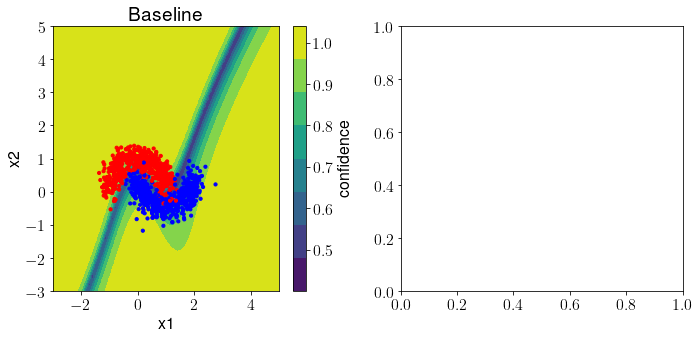

In [49]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
axs_flat = axs.flat

cmap = test(model, axs_flat[0], bayesian=False)
axs_flat[0].set_title("Baseline")

cbar = fig.colorbar(cmap, ax=axs_flat[0], ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.set_label('confidence')
fig.tight_layout();

In [50]:
model.train_LL(list(zip(x,y)), n_datapoints=n_datapoints, epochs=200, samples=2, train_hyper=True, update_freq=10)
test(model, axs_flat[1], bayesian=True)
axs_flat[1].set_title("Additional Bayesian Training")
fig.savefig("/Users/philippvonbachmann/Documents/University/ResearchProject/ResearchProjectLLVI/presentations/shortpresentation_13_11/images/TwoMoons/comparison.jpg")

Loss:0.62, Data LogLik:0.21, KL Loss:0.42: 100%|██████████| 200/200 [00:10<00:00, 19.77it/s]
